In [1]:
import numpy as np
import pymultinest

import matplotlib as mpl
import matplotlib.pyplot as plt

import json
import corner
import retrieval_base.auxiliary_functions as af

In [2]:
def plot_PT_and_contr(ax_PT, ax_contr, PT, int_contr_em, envelope_colors, posterior_color, ls='-'):

    ax_PT.fill_betweenx(
        y=PT.pressure, x1=PT.temperature_envelopes[1], 
        x2=PT.temperature_envelopes[-2], 
        #color=envelope_colors[3], ec='none', 
        color=envelope_colors[2], ec='none', 
        )
    ax_PT.plot(
        PT.temperature_envelopes[3], PT.pressure, 
        c=posterior_color, lw=1, ls=ls
        )
    ax_contr.plot(
        int_contr_em, PT.pressure, c=posterior_color, lw=1, ls=ls
        )
    
def plot_VMR_profile(
        ax, pressure, chem, species, ec, ls=['--','--'], 
        plot_unquenched=False, plot_unquenched_envelope=False, relative_to_12CO=True
        ):

    cmap = mpl.colors.LinearSegmentedColormap.from_list(
            #'cmap', colors=['w', ec]
            'cmap', colors=['none', ec]
            )
    fc = cmap(0.8)

    # Read MMW posterior
    MMW = chem.mass_fractions_posterior['MMW']
    
    if relative_to_12CO:
        mass = chem.read_species_info('12CO', info_key='mass')
        line_species = chem.read_species_info('12CO', info_key='pRT_name')
        posterior_12CO = MMW/mass * chem.mass_fractions_posterior[line_species]

    mass = chem.read_species_info(species, info_key='mass')
    line_species = chem.read_species_info(species, info_key='pRT_name')
    posterior_X = MMW/mass * chem.mass_fractions_posterior[line_species]

    print(np.log10(np.median(posterior_X)))
    if relative_to_12CO:
        posterior_X /= posterior_12CO

    envelope_X = np.array(
        [af.quantiles(posterior_X[:,i], q=q) for i in range(posterior_X.shape[1])]
        ).T

    if isinstance(ls, list):
        ls_1, ls_2 = ls
    else:
        ls_1 = ls
        ls_2 = ls
    
    #'''
    ax.plot(
        envelope_X[3], pressure, c=ec, lw=1, ls=ls_1
        )
    ax.fill_betweenx(
        y=pressure, x1=envelope_X[1], x2=envelope_X[-2], 
        #fc=fc, alpha=0.3, ec='none', #ec=colors[i], ls='--'
        fc=ec, alpha=0.25, ec='none', #ec=colors[i], ls='--'
        )
    #'''
    if hasattr(chem, 'unquenched_mass_fractions_posterior') and plot_unquenched:

        unquenched_mass_fractions_i = \
            chem.unquenched_mass_fractions_posterior.get(line_species.split('_')[0])
        unquenched_posterior_X = MMW/mass * unquenched_mass_fractions_i

        if relative_to_12CO:
            unquenched_posterior_X /= posterior_12CO

        unquenched_envelope_X = np.array(
            [af.quantiles(unquenched_posterior_X[:,i], q=q) 
             for i in range(unquenched_posterior_X.shape[1])]
            ).T

        ax.plot(
            unquenched_envelope_X[3], pressure, 
            c=ec, lw=1, ls=ls_2, alpha=0.5
            )
        if plot_unquenched_envelope:
            ax.fill_betweenx(
                y=pressure, x1=unquenched_envelope_X[1], x2=unquenched_envelope_X[-2], 
                fc=fc, alpha=0.3*1/3, ec='none', #ec=colors[i], ls='--'
                #fc=fc, alpha=0.3, ec='none', #ec=colors[i], ls='--'
                )

def plot_hist1d(ax, posterior, ec, fc, xrange, bins=25, ls='-', ymarker=0.05, label=None):

    q = np.array([0.5-0.997/2, 0.5-0.95/2, 0.5-0.68/2, 0.5, 0.5+0.68/2, 0.5+0.95/2, 0.5+0.997/2])

    _, _, p = ax.hist(
        posterior, bins=bins, range=xrange, histtype='step', fill=True, 
        ec=ec, fc=fc, ls=ls, label=label, zorder=-1
        )

    median = np.median(posterior)
    xerr = np.abs(np.quantile(posterior, q=q[[1,-2]])-median)[:,None]
    ax.errorbar(
        median, ymarker, xerr=xerr, fmt='o', 
        c=ec, capthick=2, elinewidth=2, markersize=4, 
        transform=ax.get_xaxis_transform(), 
        )

    xerr = np.abs(np.quantile(posterior, q=q[[2,-3, 1,-2, 0,-1]])-median)[:,None]
    print('{:} | -{:}+{:} | -{:}+{:} | -{:}+{:}'.format(median, *xerr.flatten()))

    return p[0]


In [3]:
def read_results(prefix, n_params):

    # Set-up analyzer object
    analyzer = pymultinest.Analyzer(
        n_params=n_params, 
        outputfiles_basename=prefix
        )
    stats = analyzer.get_stats()

    # Load the equally-weighted posterior distribution
    posterior = analyzer.get_equal_weighted_posterior()
    posterior = posterior[:,:-1]

    # Read the parameters of the best-fitting model
    bestfit = np.array(stats['modes'][0]['maximum a posterior'])

    PT = af.pickle_load(prefix+'data/bestfit_PT.pkl')
    Chem = af.pickle_load(prefix+'data/bestfit_Chem.pkl')

    m_spec = af.pickle_load(prefix+'data/bestfit_m_spec.pkl')
    d_spec = af.pickle_load(prefix+'data/d_spec.pkl')

    LogLike = af.pickle_load(prefix+'data/bestfit_LogLike.pkl')

    try:
        Cov = af.pickle_load(prefix+'data/bestfit_Cov.pkl')
    except:
        Cov = None

    int_contr_em           = np.load(prefix+'data/bestfit_int_contr_em.npy')
    int_contr_em_per_order = np.load(prefix+'data/bestfit_int_contr_em_per_order.npy')
    int_opa_cloud          = np.load(prefix+'data/bestfit_int_opa_cloud.npy')

    f = open(prefix+'data/bestfit.json')
    bestfit_params = json.load(f)
    f.close()

    print(posterior.shape)
    return posterior, bestfit, PT, Chem, int_contr_em, int_contr_em_per_order, int_opa_cloud, m_spec, d_spec, LogLike, Cov, bestfit_params

res = read_results(
    prefix='./retrieval_outputs/DENIS_J0255_nominal_5/test_', n_params=32
    )
posterior_1, bestfit_1, PT_1, Chem_1, int_contr_em_1, int_contr_em_per_order_1, int_opa_cloud_1, m_spec_1, d_spec_1, LogLike_1, Cov_1, bestfit_params_1 = res

#res = read_results(
#    prefix='./retrieval_outputs/DENIS_J0255_chem_eq_Pquench_13CO/test_', n_params=29
#    )
#posterior_2, bestfit_2, PT_2, Chem_2, int_contr_em_2, int_contr_em_per_order_2, int_opa_cloud_2, m_spec_2, d_spec_2, LogLike_2, Cov_2, bestfit_params_2 = res
res = read_results(
    #prefix='./retrieval_outputs/DENIS_J0255_chem_eq_Pquench_all/test_', n_params=32
    prefix='./retrieval_outputs/DENIS_J0255_chem_eq_Pquench_all_2/test_', n_params=32
    )
posterior_2, bestfit_2, PT_2, Chem_2, int_contr_em_2, int_contr_em_per_order_2, int_opa_cloud_2, m_spec_2, d_spec_2, LogLike_2, Cov_2, bestfit_params_2 = res

res = read_results(
    prefix='./retrieval_outputs/DENIS_J0255_chem_eq_wo_Pquench_13CO/test_', n_params=28
    )
posterior_3, bestfit_3, PT_3, Chem_3, int_contr_em_3, int_contr_em_per_order_3, int_opa_cloud_3, m_spec_3, d_spec_3, LogLike_3, Cov_3, bestfit_params_3 = res

res = read_results(
    #prefix='./retrieval_outputs/DENIS_J0255_chem_eq_log_Kzz/test_', n_params=29
    prefix='./retrieval_outputs/DENIS_J0255_chem_eq_log_Kzz_4/test_', n_params=29
    )
posterior_4, bestfit_4, PT_4, Chem_4, int_contr_em_4, int_contr_em_per_order_4, int_opa_cloud_4, m_spec_4, d_spec_4, LogLike_4, Cov_4, bestfit_params_4 = res

del res

  analysing data from ./retrieval_outputs/DENIS_J0255_nominal_5/test_.txt
(4331, 32)
  analysing data from ./retrieval_outputs/DENIS_J0255_chem_eq_Pquench_all_2/test_.txt
(4027, 32)
  analysing data from ./retrieval_outputs/DENIS_J0255_chem_eq_wo_Pquench_13CO/test_.txt
(4883, 28)
  analysing data from ./retrieval_outputs/DENIS_J0255_chem_eq_log_Kzz_4/test_.txt
(4356, 29)


In [5]:
res = read_results(
    prefix='./retrieval_outputs/DENIS_J0255_wo_CH4/test_', n_params=31
    )
posterior_wo_CH4, *_ = res
del res

res = read_results(
    prefix='./retrieval_outputs/DENIS_J0255_wo_NH3/test_', n_params=31
    )
posterior_wo_NH3, *_ = res
del res

  analysing data from ./retrieval_outputs/DENIS_J0255_wo_CH4/test_.txt
(4265, 31)
  analysing data from ./retrieval_outputs/DENIS_J0255_wo_NH3/test_.txt
(4365, 31)


In [15]:
q = np.array([
    0.5-0.997/2, 0.5-0.95/2, 0.5-0.68/2, 0.5, 
    0.5+0.68/2, 0.5+0.95/2, 0.5+0.997/2
    ])
print(
    np.nanmedian(10**(posterior_1[:,16] - posterior_1[:,20])), 
    np.quantile(10**(posterior_1[:,16] - posterior_1[:,20]), q=q[[2,4]]) - np.nanmedian(10**(posterior_1[:,16] - posterior_1[:,20]))
    )
print(
    np.nanmedian(10**(posterior_wo_NH3[:,16] - posterior_wo_NH3[:,19])), 
    np.quantile(10**(posterior_wo_NH3[:,16] - posterior_wo_NH3[:,19]), q=q[[2,4]]) - np.nanmedian(10**(posterior_wo_NH3[:,16] - posterior_wo_NH3[:,19]))
    )
print(
    np.nanmedian(10**(posterior_wo_CH4[:,16] - posterior_wo_CH4[:,19])), 
    np.quantile(10**(posterior_wo_CH4[:,16] - posterior_wo_CH4[:,19]), q=q[[2,4]]) - np.nanmedian(10**(posterior_wo_CH4[:,16] - posterior_wo_CH4[:,19]))
    )

183.6681548180839 [-39.53751907  61.31263935]
185.9680445666921 [-40.02186723  60.63696985]
166.25345730261472 [-39.24475091  70.80668091]


In [4]:
def get_env_colors(post_color):

    env_cmap = mpl.colors.LinearSegmentedColormap.from_list(
        name='env_cmap', colors=[post_color, post_color], 
        )
    env_colors = env_cmap([0.0,0.2,0.4,0.5,0.8])
    env_colors[:,-1] = np.array([0.0,0.2,0.35,0.5,0.65])

    return env_cmap, env_colors

#cmap = plt.get_cmap('RdPu')

#posterior_color_1 = cmap(0.65)
#posterior_color_2 = '#0fbca5'
#posterior_color_3 = '#ff6334'

posterior_color_1 = '#8B077C'
posterior_color_2 = '#075B56'
posterior_color_3 = '#C25617'
posterior_color_4 = '#85BAB6'

envelope_cmap_1, envelope_colors_1 = get_env_colors(posterior_color_1)
envelope_cmap_2, envelope_colors_2 = get_env_colors(posterior_color_2)
envelope_cmap_3, envelope_colors_3 = get_env_colors(posterior_color_3)
envelope_cmap_4, envelope_colors_4 = get_env_colors(posterior_color_4)

In [4]:
upper_K_zz = 2.5e10 * (1400/600)**(8/3) * (1000/10**bestfit_params_2['params']['log_g'])
print('Upper K_zz < {:.3e} cm s^-2'.format(upper_K_zz))

upper_K_zz = 2.5e10 * (1400/600)**(8/3) * (1000/10**bestfit_params_4['params']['log_g'])
print('Upper K_zz < {:.3e} cm s^-2'.format(upper_K_zz))

Upper K_zz < 1.122e+09 cm s^-2
Upper K_zz < 1.385e+09 cm s^-2


In [5]:
q = np.array([
    0.5-0.997/2, 0.5-0.95/2, 0.5-0.68/2, 0.5, 
    0.5+0.68/2, 0.5+0.95/2, 0.5+0.997/2
    ])
param_quantiles_2 = np.array(
    [af.quantiles(posterior_2[:,i], q=q) for i in range(posterior_2.shape[1])]
    )
print(param_quantiles_2.shape)
for _, _, a, b, c, _, _ in param_quantiles_2:
    print('$' + '{:.2f}'.format(b) + r'^{+' + '{:.2f}'.format(c-b) + r'}_{-' + '{:.2f}'.format(b-a) + r'}' + '$')
    #print('$' + '{:.3f}'.format(b) + r'^{+' + '{:.3f}'.format(c-b) + r'}_{-' + '{:.3f}'.format(b-a) + r'}' + '$')
    
    #print('$' + '{:.0f}'.format(b) + r'^{+' + '{:.0f}'.format(c-b) + r'}_{-' + '{:.0f}'.format(b-a) + r'}' + '$')
    print()
    #print(a, b, c)

(32, 7)
$0.60^{+0.04}_{-0.04}$

$0.44^{+0.03}_{-0.03}$

$0.32^{+0.02}_{-0.02}$

$0.31^{+0.02}_{-0.02}$

$0.32^{+0.02}_{-0.02}$

$0.51^{+0.03}_{-0.02}$

$0.65^{+0.03}_{-0.03}$

$23.44^{+0.97}_{-0.94}$

$0.77^{+0.01}_{-0.01}$

$5.31^{+0.04}_{-0.03}$

$0.65^{+0.03}_{-0.03}$

$41.04^{+0.18}_{-0.18}$

$22.56^{+0.07}_{-0.07}$

$-4.77^{+3.00}_{-2.97}$

$-1.79^{+2.82}_{-2.47}$

$9.76^{+5.68}_{-5.42}$

$0.63^{+0.00}_{-0.00}$

$0.06^{+0.02}_{-0.03}$

$1.47^{+0.06}_{-0.06}$

$0.24^{+0.11}_{-0.12}$

$-2.14^{+2.20}_{-2.28}$

$-2.00^{+2.25}_{-2.24}$

$-2.26^{+0.10}_{-0.12}$

$1.17^{+0.72}_{-0.57}$

$4653.86^{+678.01}_{-782.86}$

$3254.53^{+295.36}_{-237.36}$

$1866.59^{+42.29}_{-42.22}$

$1545.16^{+22.41}_{-22.21}$

$1149.28^{+24.92}_{-24.69}$

$742.99^{+22.70}_{-22.64}$

$1130.71^{+522.45}_{-568.19}$

$0.23^{+0.04}_{-0.05}$



In [6]:
q = np.array([
    0.5-0.997/2, 0.5-0.95/2, 0.5-0.68/2, 0.5, 
    0.5+0.68/2, 0.5+0.95/2, 0.5+0.997/2
    ])
param_quantiles_4 = np.array(
    [af.quantiles(posterior_4[:,i], q=q) for i in range(posterior_4.shape[1])]
    )
print(param_quantiles_4.shape)
for _, _, a, b, c, _, _ in param_quantiles_4:
    #print('$' + '{:.2f}'.format(b) + r'^{+' + '{:.2f}'.format(c-b) + r'}_{-' + '{:.2f}'.format(b-a) + r'}' + '$')
    #print('$' + '{:.3f}'.format(b) + r'^{+' + '{:.3f}'.format(c-b) + r'}_{-' + '{:.3f}'.format(b-a) + r'}' + '$')
    
    #print('$' + '{:.0f}'.format(b) + r'^{+' + '{:.0f}'.format(c-b) + r'}_{-' + '{:.0f}'.format(b-a) + r'}' + '$')
    #print()
    #print(a, b, c)
    pass

for key_i, P_quench_post_i in Chem_4.P_quench_posterior.items():
    
    print(key_i)
    _, _, a, b, c, _, _ = np.quantile(np.log10(P_quench_post_i), q=q)
    print('$' + '{:.2f}'.format(b) + r'^{+' + '{:.2f}'.format(c-b) + r'}_{-' + '{:.2f}'.format(b-a) + r'}' + '$')
    #print('$' + '{:.3f}'.format(b) + r'^{+' + '{:.3f}'.format(c-b) + r'}_{-' + '{:.3f}'.format(b-a) + r'}' + '$')
    #print('$' + '{:.0f}'.format(b) + r'^{+' + '{:.0f}'.format(c-b) + r'}_{-' + '{:.0f}'.format(b-a) + r'}' + '$')
    print()

(29, 7)
P_quench_CO_CH4
$1.24^{+0.02}_{-0.02}$

P_quench_NH3
$1.29^{+0.02}_{-0.02}$

P_quench_HCN
$1.29^{+0.02}_{-0.02}$

P_quench_CO2
$0.49^{+0.03}_{-0.03}$



In [7]:
q = np.array([
    0.5-0.997/2, 0.5-0.95/2, 0.5-0.68/2, 0.5, 
    0.5+0.68/2, 0.5+0.95/2, 0.5+0.997/2
    ])

print(
    np.quantile(posterior_2[:,16], q=q) - np.quantile(posterior_2[:,16], q=q[3]), 
    np.quantile(posterior_2[:,16], q=q[3])
    )
print(
    np.quantile(posterior_4[:,16], q=q) - np.quantile(posterior_4[:,16], q=q[3]), 
    np.quantile(posterior_4[:,16], q=q[3])
    )

print(
    np.quantile(posterior_2[:,17], q=q) - np.quantile(posterior_2[:,17], q=q[3]), 
    np.quantile(posterior_2[:,17], q=q[3])
    )
print(
    np.quantile(posterior_4[:,17], q=q) - np.quantile(posterior_4[:,17], q=q[3]), 
    np.quantile(posterior_4[:,17], q=q[3])
    )

print(
    np.quantile(1/10**posterior_2[:,22], q=q) - np.quantile(1/10**posterior_2[:,22], q=q[3]), 
    np.quantile(1/10**posterior_2[:,22], q=q[3])
    )
print(
    np.quantile(1/10**posterior_4[:,18], q=q) - np.quantile(1/10**posterior_4[:,18], q=q[3]), 
    np.quantile(1/10**posterior_4[:,18], q=q[3])
    )

[-0.01318929 -0.00774659 -0.003913    0.          0.00384183  0.00744635
  0.0119456 ] 0.6314054718915137
[-0.01557443 -0.00988519 -0.00490874  0.          0.00483228  0.00888063
  0.0129051 ] 0.638664032503029
[-0.08039839 -0.05184537 -0.02618607  0.          0.02496254  0.04929694
  0.07365019] 0.05500691579778372
[-0.09010678 -0.06107143 -0.03110144  0.          0.02725988  0.05248617
  0.06944544] 0.018546679510270225
[ -86.55911678  -62.68826624  -36.67307614    0.           57.08036317
  172.91773598 5993.95865634] 180.96308991640095
[  -79.82534312   -63.93384315   -37.49739275     0.
    60.73227181   173.46274224 18587.92073718] 181.65989060606793


In [8]:
q = np.array([
    0.5-0.997/2, 0.5-0.95/2, 0.5-0.68/2, 0.5, 
    0.5+0.68/2, 0.5+0.95/2, 0.5+0.997/2
    ])

print(
    np.quantile(Chem_2.P_quench_posterior['P_quench_CO_CH4'], q=q) - \
        np.quantile(Chem_2.P_quench_posterior['P_quench_CO_CH4'], q=q[3]), 
    np.quantile(Chem_2.P_quench_posterior['P_quench_CO_CH4'], q=q[3])
    )
print()
print(
    np.quantile(Chem_2.P_quench_posterior['P_quench_NH3'], q=q) - \
        np.quantile(Chem_2.P_quench_posterior['P_quench_NH3'], q=q[3]), 
    np.quantile(Chem_2.P_quench_posterior['P_quench_NH3'], q=q[3])
    )

[-8.86527017 -6.13712802 -3.60022804  0.          4.16502503  8.53719082
 12.64386842] 29.648345554798777

[-1.06647607 -0.75338772 -0.42686282  0.          0.50529932  1.07967401
  1.76158903] 1.7219664800435512


In [9]:
print(
    np.quantile(Chem_2.P_quench_posterior['P_quench_CO2'], q=q) - \
        np.quantile(Chem_2.P_quench_posterior['P_quench_CO2'], q=q[3]), 
    np.quantile(Chem_2.P_quench_posterior['P_quench_CO2'], q=q[3])
    )
print()
print(
    np.quantile(Chem_2.P_quench_posterior['P_quench_HCN'], q=q) - \
        np.quantile(Chem_2.P_quench_posterior['P_quench_HCN'], q=q[3]), 
    np.quantile(Chem_2.P_quench_posterior['P_quench_HCN'], q=q[3])
    )

[-9.95807804e-03 -9.95688189e-03 -9.90132516e-03  0.00000000e+00
  1.77248541e+00  4.22769266e+01  9.78041440e+01] 0.009959182401916632

[-7.29110782e-03 -7.28993097e-03 -7.25408720e-03  0.00000000e+00
  1.14008080e+00  3.23136649e+01  8.60048487e+01] 0.007292140464240461


In [10]:
print(
    np.quantile(Chem_4.P_quench_posterior['P_quench_CO_CH4'], q=q) - \
        np.quantile(Chem_4.P_quench_posterior['P_quench_CO_CH4'], q=q[3]), 
    np.quantile(Chem_4.P_quench_posterior['P_quench_CO_CH4'], q=q[3])
    )
print()
print(
    np.quantile(Chem_4.P_quench_posterior['P_quench_NH3'], q=q) - \
        np.quantile(Chem_4.P_quench_posterior['P_quench_NH3'], q=q[3]), 
    np.quantile(Chem_4.P_quench_posterior['P_quench_NH3'], q=q[3])
    )

[-3.0902648  -1.82999497 -0.8993892   0.          0.85407095  1.74890474
  2.89569344] 17.449470256332326

[-3.27401623 -2.06758562 -1.0423999   0.          1.06204605  2.23559304
  3.7277644 ] 19.48883859711895


In [5]:
q = np.array([
    0.5-0.997/2, 0.5-0.95/2, 0.5-0.68/2, 0.5, 
    0.5+0.68/2, 0.5+0.95/2, 0.5+0.997/2
    ])
param_quantiles = np.array(
    [af.quantiles(10**posterior_1[:,i]/10**posterior_1[:,16], q=q) \
     for i in range(posterior_1.shape[1])]
    )

/tmp/ipykernel_82916/2606121561.py:6: RuntimeWarning: overflow encountered in power
  [af.quantiles(10**posterior_1[:,i]/10**posterior_1[:,16], q=q) \
/home/sam/Documents/PhD/CRIRES_data_reduction/crires_venv/lib/python3.10/site-packages/numpy/lib/function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/tmp/ipykernel_82916/2606121561.py:6: RuntimeWarning: overflow encountered in divide
  [af.quantiles(10**posterior_1[:,i]/10**posterior_1[:,16], q=q) \


In [19]:
fig = plt.figure(figsize=(9,4))

wspace = 0.05
gs = mpl.gridspec.GridSpec(ncols=4, nrows=3, figure=fig, width_ratios=[0.8,1,wspace,0.5], wspace=0.0, hspace=0.35)

ax_VMR = fig.add_subplot(gs[:,0])
ax_PT = fig.add_subplot(gs[:,1])

ax_hist1d = [
    fig.add_subplot(gs[0,-1]), 
    fig.add_subplot(gs[1,-1]), 
    fig.add_subplot(gs[2,-1]), 
]

# ==================================================================================
#y_1 = 0.075
y_1 = 0.18
ax_VMR.plot(
    [0,1], [y_1,y_1], transform=ax_VMR.transAxes, 
    c=envelope_colors_1[1], lw=1
    )
ax_VMR.annotate(
    'Free-chem.', xy=(0.0,y_1), xycoords=ax_VMR.transAxes, 
    xytext=(-0.02,y_1), 
    va='center', ha='right', color=posterior_color_1, fontsize=9, 
    arrowprops={
        'arrowstyle':'-', 'connectionstyle':'arc3', 
        'shrinkA':25, 'shrinkB':0, 'lw':1, 'color':envelope_colors_1[1], 
        }
)

#colors = ['C2', 'C3', 'C4', 'C8', 'C5', 'k', 'C0']
#labels = [r'$^{12}$CO', r'H$_2$O', r'CH$_4$', r'NH$_3$', r'$^{13}$CO', r'CO$_2$', 'HCN']
#species = ['12CO', 'H2O', 'CH4', 'NH3', '13CO', 'CO2', 'HCN']
#for i, idx in enumerate([16,17,18,19,20,21,22]):

colors = ['C2', 'C3', 'C4', 'C8', 'C5']
labels = [r'$^{12}$CO', r'H$_2$O', r'CH$_4$', r'NH$_3$', r'$^{13}$CO']
species = ['12CO', 'H2O', 'CH4', 'NH3', '13CO']
for i, idx in enumerate([16,17,18,19,20]):

    median = param_quantiles[idx,3]
    xerr = np.abs(param_quantiles[idx,:]-median)

    print(species[i])
    print(
        np.median(posterior_1[:,idx], axis=-1)
        )

    ax_VMR.errorbar(
        x=median, y=y_1, xerr=xerr[[1,-2]][:,None], 
        c=colors[i], label=labels[i], capthick=2, elinewidth=2, 
        fmt='o', markersize=4, 
        transform=ax_VMR.get_xaxis_transform()
    )
    #plot_VMR_profile(ax_VMR, PT_1.pressure, Chem_1, species=species[i], ec=colors[i], ls='-')

    plot_VMR_profile(ax_VMR, PT_2.pressure, Chem_2, species=species[i], ec=colors[i], ls='--')
    plot_VMR_profile(ax_VMR, PT_4.pressure, Chem_4, species=species[i], ec=colors[i], ls='-.')

    if species[i] != '13CO':
        plot_VMR_profile(ax_VMR, PT_3.pressure, Chem_3, species=species[i], ec=colors[i], ls=':')

ax_VMR.annotate(
    text=labels[0], xy=(10**(-0.14), y_1+0.02), xycoords=ax_VMR.get_xaxis_transform(), 
    va='bottom', ha='left', color=colors[0], fontsize=9, rotation=90
)
ax_VMR.annotate(
    text=labels[1], xy=(10**(-0.37), y_1+0.02), xycoords=ax_VMR.get_xaxis_transform(), 
    va='bottom', ha='right', color=colors[1], fontsize=9, rotation=90
)
ax_VMR.annotate(
    text=labels[2], xy=(10**(-1.53), y_1+0.05), xycoords=ax_VMR.get_xaxis_transform(), 
    va='bottom', ha='left', color=colors[2], fontsize=9, rotation=90
)
ax_VMR.annotate(
    text=labels[3], xy=(10**(-2.55), y_1+0.02), xycoords=ax_VMR.get_xaxis_transform(), 
    va='bottom', ha='right', color=colors[3], fontsize=9, rotation=90
)
ax_VMR.annotate(
    text=labels[4], xy=(10**(-2.04), y_1+0.02), xycoords=ax_VMR.get_xaxis_transform(), 
    va='bottom', ha='left', color=colors[4], fontsize=9, rotation=90
)

ax_VMR.set(
    yscale='log', ylim=(1e-6,1e2), ylabel=r'$P\ (\mathrm{bar})$', 
    xscale='log', xlim=(10**(-3.),10**(0.1)), xlabel=r'$\mathrm{VMR}(X_i)\ /\ \mathrm{VMR(^{12}CO)}$', 
    #xscale='log', xlim=(10**(-5),10**(0.6)), xlabel=r'$\mathrm{VMR}(X_i)\ /\ \mathrm{VMR(^{12}CO)}$', 
    )
ax_VMR.invert_yaxis()

# ==================================================================================
ax_PT.set(
    yscale='log', ylim=(1e-6,1e2), yticks=[], #ylabel=r'$P\ (\mathrm{bar})$', 
    xlim=(1,2500), xlabel=r'$T\ (\mathrm{K})$', 
    )
ax_PT.invert_yaxis()
    
ax_contr = ax_PT.twiny()

plot_PT_and_contr(ax_PT, ax_contr, PT_1, int_contr_em_1, envelope_colors_1, posterior_color_1, ls='-')
plot_PT_and_contr(ax_PT, ax_contr, PT_2, int_contr_em_2, envelope_colors_2, posterior_color_2, ls='--')
plot_PT_and_contr(ax_PT, ax_contr, PT_3, int_contr_em_3, envelope_colors_3, posterior_color_3, ls=':')
plot_PT_and_contr(ax_PT, ax_contr, PT_4, int_contr_em_4, envelope_colors_4, posterior_color_4, ls='-.')

q = np.array([0.5-0.997/2, 0.5-0.95/2, 0.5-0.68/2, 0.5, 0.5+0.68/2, 0.5+0.95/2, 0.5+0.997/2])
'''
median = 10**af.quantiles(posterior_2[:,18], q=q)[3]
yerr = np.abs(10**af.quantiles(posterior_2[:,18], q=q)[[1,-2]] - median)

ax_contr.errorbar(
    x=0.05, y=median, yerr=yerr[:,None], transform=ax_contr.get_yaxis_transform(), 
    c=posterior_color_2, fmt='o', capthick=1, elinewidth=2, markersize=4, 
)
ax_contr.annotate(
    text=r'$P_\mathrm{quench,CH_4}$', xy=(0.07, median), xycoords=ax_contr.get_yaxis_transform(), 
    va='center', ha='left', color=posterior_color_2, fontsize=9
)

median = 10**af.quantiles(posterior_2[:,19], q=q)[3]
yerr = np.abs(10**af.quantiles(posterior_2[:,19], q=q)[[1,-2]] - median)

ax_contr.errorbar(
    x=0.05, y=median, yerr=yerr[:,None], transform=ax_contr.get_yaxis_transform(), 
    c=posterior_color_2, fmt='o', capthick=1, elinewidth=2, markersize=4, 
)
ax_contr.annotate(
    text=r'$P_\mathrm{quench,NH_3}$', xy=(0.07, median), xycoords=ax_contr.get_yaxis_transform(), 
    va='center', ha='left', color=posterior_color_2, fontsize=9
)
'''
ax_contr.annotate(
    text=r'Emission contribution', 
    xy=(np.max(int_contr_em_3), PT_1.pressure[np.argmax(int_contr_em_3)]), 
    xytext=(1.2*np.max(int_contr_em_1), 11), 
    ha='center', va='top', fontsize=9, 
    arrowprops={
        'arrowstyle':'-', 'connectionstyle':'angle3,angleA=90,angleB=0', 
        'shrinkA':0, 'shrinkB':12, #'arrowstyle':']-',
        'lw':1, 'color':'k', 'alpha':0.2, 
        }
    )

ax_contr.set(xlim=(0, 3*np.nanmax(int_contr_em_1)), yscale='log', ylim=(1e2,1e-6), yticks=[], xticks=[])
ax_contr.tick_params(
    axis='x', which='both', top=False, labeltop=False
    )

# ==================================================================================
labels = ['C/O', '[Fe/H] or [C/H]', r'$^{12}$C/$^{13}$C', 'none']

for i, ax_i in enumerate(ax_hist1d):
    ax_i.set_yticks([])
    #ax_i.set(xlabel=labels[i])
    ax_i.annotate(labels[i], xy=(0.98,0.95), xycoords='axes fraction', va='top', ha='right')

patches = []
CO_range = (0.53,0.71)
CO_bins = np.arange(CO_range[0], CO_range[1]+1e-6, 0.0025)

FeH_range = (-0.08,1.0)
FeH_bins = np.arange(FeH_range[0], FeH_range[1]+1e-6, 0.02)

C_ratio_range = (50,500)
C_ratio_bins = np.arange(C_ratio_range[0], C_ratio_range[1]+1e-6, 20)

# -------------------------------------------------------------
plot_hist1d(
    ax_hist1d[0], Chem_1.CO_posterior, 
    ec=posterior_color_1, fc=envelope_colors_1[1], 
    xrange=CO_range, bins=CO_bins, ymarker=0.05
    )

plot_hist1d(
    ax_hist1d[1], Chem_1.FeH_posterior, 
    ec=posterior_color_1, fc=envelope_colors_1[1], 
    xrange=FeH_range, bins=FeH_bins, ymarker=0.05
    )

indices = [16,20,17,18,19]
Chem_1.C_ratio_posterior = 10**posterior_1[:,indices[0]] / 10**posterior_1[:,indices[1]]

p = plot_hist1d(
    ax_hist1d[2], Chem_1.C_ratio_posterior, 
    ec=posterior_color_1, fc=envelope_colors_1[1], 
    xrange=C_ratio_range, bins=C_ratio_bins, ymarker=0.05, 
    label=r'Free-chemistry ($-$)'
    )
patches.append(p)

# -------------------------------------------------------------
plot_hist1d(
    ax_hist1d[0], Chem_2.CO_posterior, 
    ec=posterior_color_2, fc=envelope_colors_2[1], ls='--', 
    xrange=CO_range, bins=CO_bins, ymarker=0.1
    )

plot_hist1d(
    ax_hist1d[1], Chem_2.FeH_posterior, 
    ec=posterior_color_2, fc=envelope_colors_2[1], ls='--', 
    xrange=FeH_range, bins=FeH_bins, ymarker=0.1
    )

#Chem_2.C_ratio_posterior = 10**(-posterior_2[:,19])
Chem_2.C_ratio_posterior = 10**(-posterior_2[:,22])
#Chem_2.C_ratio_posterior = 10**(-posterior_2[:,18])
p = plot_hist1d(
    ax_hist1d[2], Chem_2.C_ratio_posterior, 
    ec=posterior_color_2, fc=envelope_colors_2[1], ls='--', 
    xrange=C_ratio_range, bins=C_ratio_bins, ymarker=0.1, 
    #label='Equilibrium chemistry\n' + r'with $P_\mathrm{quench}$'
    #label='Quenched equilibrium\nchemistry'
    #label=r'Eq.-chem. ($P_\mathrm{quench}$)'
    label=r'Quenched ($P_\mathrm{quench}$)'+'\n'+r'($-3.4\sigma$)'
    )
patches.append(p)

# -------------------------------------------------------------
plot_hist1d(
    ax_hist1d[0], Chem_4.CO_posterior, 
    ec=posterior_color_4, fc=envelope_colors_4[1], ls='-.', 
    xrange=CO_range, bins=CO_bins, ymarker=0.15
    )

plot_hist1d(
    ax_hist1d[1], Chem_4.FeH_posterior, 
    ec=posterior_color_4, fc=envelope_colors_4[1], ls='-.', 
    xrange=FeH_range, bins=FeH_bins, ymarker=0.15
    )

Chem_4.C_ratio_posterior = 10**(-posterior_4[:,18])
p = plot_hist1d(
    ax_hist1d[2], Chem_4.C_ratio_posterior, 
    ec=posterior_color_4, fc=envelope_colors_4[1], ls='-.', 
    xrange=C_ratio_range, bins=C_ratio_bins, ymarker=0.15, 
    #label='Equilibrium chemistry\n' + r'with $P_\mathrm{quench}$'
    #label='Quenched equilibrium\nchemistry ' + r'($K_\mathrm{zz}$)'
    #label=r'Eq.-chem. ($K_\mathrm{zz}$)'
    label=r'Quenched ($K_\mathrm{zz}$) '+'\n'+r'($-5.3\sigma$)'
    )
patches.append(p)

# -------------------------------------------------------------
p = plot_hist1d(
    ax_hist1d[0], Chem_3.CO_posterior, 
    ec=posterior_color_3, fc=envelope_colors_3[1], ls=':', 
    xrange=CO_range, bins=CO_bins, ymarker=0.2, 
    #label='Equilibrium chemistry\n' + r'without $P_\mathrm{quench}$'
    #label='Un-quenched\nequilibrium chemistry'
    label='Un-quenched\neq.-chem. ' + r'($-29.0\sigma$)'
    )

plot_hist1d(
    ax_hist1d[1], Chem_3.FeH_posterior, 
    ec=posterior_color_3, fc=envelope_colors_3[1], ls=':', 
    xrange=FeH_range, bins=FeH_bins, ymarker=0.2
    )

Chem_3.C_ratio_posterior = 10**(-posterior_3[:,19])
#plot_hist1d(
#    ax_hist1d[2], Chem_3.C_ratio_posterior, 
#    ec=posterior_color_3, fc=envelope_colors_3[1], ls=':', 
#    xrange=C_ratio_range, bins=C_ratio_bins, ymarker=0.2, 
#    )
patches.append(p)

# -------------------------------------------------------------

ax_hist1d[1].set(xticks=np.arange(0,1.25,0.25))
ax_hist1d[2].set(xticks=np.arange(100,600,100))

ax_PT.legend(
    loc='upper right', bbox_to_anchor=(1,0.69), handles=patches, 
    #framealpha=1, edgecolor='k', fancybox=False, 
    labelspacing=0.8, fontsize=9, handlelength=1.5, handleheight=0.9
    )

l, r = 0.09, 0.98
b, t = 0.13, 0.95
fig.subplots_adjust(left=l, right=r, top=t, bottom=b, wspace=0, hspace=0)

ax_PT.xaxis.labelpad = 6
ax_VMR.xaxis.labelpad = 3

#fig.savefig('./plots/chemistry_PT_Pquench_all.pdf')
fig.savefig('./plots/chemistry_PT_new.pdf')
#fig.savefig('./plots/chemistry_PT_log_Kzz.pdf')
#plt.show()
plt.close(fig)

12CO
-3.324741226232965
-3.3008581639856573
-3.341966623201814
-2.4796603389570757
H2O
-3.616702823778332
-3.590215463540983
-3.6367653645531375
-2.808315471528237
CH4
-4.916778826672724
-4.8875426240591135
-4.942246094519348
-4.166728619140188
NH3
-5.988500682527001
-5.80076227828269
-5.784678044640964
-6.7060285896690175
13CO
-5.587468048338467
-5.556885608402006
-5.600879132244134
0.6806913909211364 | -0.00478079053720204+0.004987775377476633 | -0.009388616595179089+0.0095226629284072 | -0.013508890513284522+0.014407048124916
0.0286431392485893 | -0.025887615562014157+0.026785146442087626 | -0.05021895499668282+0.05284039622780978 | -0.07362086224588402+0.07863800699593007
183.6681548180839 | -39.53751906855149+61.312639349030974 | -65.72918926519701+174.23361188082941 | -86.82120946893059+547.5778356686533
0.6314054718915137 | -0.003913002517615505+0.0038418289260216953 | -0.007746589997922548+0.007446349444194977 | -0.013189288347336015+0.01194559947680951
0.05500691579778372 | -0

In [7]:
q = np.array([
    0.5-0.997/2, 0.5-0.95/2, 0.5-0.68/2, 0.5, 
    0.5+0.68/2, 0.5+0.95/2, 0.5+0.997/2
    ])
param_quantiles = np.array(
    [af.quantiles(10**posterior_4[:,i], q=q) \
     for i in range(posterior_4.shape[1])]
    )
print('{:.1e}'.format(param_quantiles[19][3]))
print((param_quantiles[19][2]-param_quantiles[19][3])/1e9, (param_quantiles[19][4]-param_quantiles[19][3])/1e9)

3.7e+09
-0.584676372347064 0.6577215719567218


/tmp/ipykernel_112724/959543868.py:6: RuntimeWarning: overflow encountered in power
  [af.quantiles(10**posterior_4[:,i], q=q) \
/home/sam/Documents/PhD/CRIRES_data_reduction/crires_venv/lib/python3.10/site-packages/numpy/lib/function_base.py:4573: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


In [14]:
q = np.array([
    0.5-0.997/2, 0.5-0.95/2, 0.5-0.68/2, 0.5, 
    0.5+0.68/2, 0.5+0.95/2, 0.5+0.997/2
    ])
param_quantiles = np.array(
    [af.quantiles(10**posterior_1[:,i], q=q) \
     for i in range(posterior_1.shape[1])]
    )

/tmp/ipykernel_112724/1067655969.py:6: RuntimeWarning: overflow encountered in power
  [af.quantiles(10**posterior_1[:,i], q=q) \
/home/sam/Documents/PhD/CRIRES_data_reduction/crires_venv/lib/python3.10/site-packages/numpy/lib/function_base.py:4573: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


In [99]:
fig, ax = plt.subplots(
    figsize=(4,4), facecolor='none'
    )

#colors = ['C2', 'C3', 'C4']#, 'C8', 'C5']
#labels = [r'$^{12}$CO', r'H$_2$O', r'CH$_4$']#, r'NH$_3$', r'$^{13}$CO']
#species = ['12CO', 'H2O', 'CH4']#, 'NH3', '13CO']
colors = ['C2', 'C3', 'C4', 'C8']
labels = [r'$^{12}$CO', r'H$_2$O', r'CH$_4$', r'NH$_3$']
species = ['12CO', 'H2O', 'CH4', 'NH3']

for color_i, label_i, species_i in zip(colors, labels, species):
    plot_VMR_profile(
        ax, PT_2.pressure, Chem_2, species_i, ec=color_i, ls=['--',(0,(10,8))], 
        plot_unquenched=True, plot_unquenched_envelope=True, relative_to_12CO=False
    )

y_1 = 0.18

ax.plot(
    [0,1], [y_1,y_1], transform=ax.transAxes, 
    c=envelope_colors_1[1], lw=1
    )
ax.annotate(
    'Free-chem.', xy=(0.0,y_1), xycoords=ax.transAxes, 
    xytext=(-0.01,y_1), 
    va='center', ha='right', color=posterior_color_1, fontsize=9, 
    arrowprops={
        'arrowstyle':'-', 'connectionstyle':'arc3', 
        'shrinkA':25, 'shrinkB':0, 'lw':1, 'color':envelope_colors_1[1], 
        }
)
#
#for i, idx in enumerate([16,17,18]):
for i, idx in enumerate([16,17,18,19]):

    median = param_quantiles[idx,3]
    xerr = np.abs(param_quantiles[idx,:]-median)

    ax.errorbar(
        x=median, y=y_1, xerr=xerr[[1,-2]][:,None], 
        c=colors[i], #label=labels[i], 
        capthick=2, elinewidth=2, fmt='o', markersize=4, 
        transform=ax.get_xaxis_transform()
    )

y_1 = 0.08
ax.annotate(
    text=labels[0], xy=(10**(-3.24), y_1), xycoords=ax.get_xaxis_transform(), 
    va='bottom', ha='left', color=colors[0], fontsize=9
)
ax.annotate(
    text=labels[1], xy=(10**(-3.63), y_1), xycoords=ax.get_xaxis_transform(), 
    va='bottom', ha='right', color=colors[1], fontsize=9
)
ax.annotate(
    text=labels[2], xy=(10**(-5.22), y_1), xycoords=ax.get_xaxis_transform(), 
    va='bottom', ha='left', color=colors[2], fontsize=9
)
ax.annotate(
    text=labels[3], xy=(10**(-5.92), y_1), xycoords=ax.get_xaxis_transform(), 
    va='bottom', ha='left', color=colors[3], fontsize=9
)

q = np.array([0.5-0.997/2, 0.5-0.95/2, 0.5-0.68/2, 0.5, 0.5+0.68/2, 0.5+0.95/2, 0.5+0.997/2])

# CO-CH4 Pquench
median = 10**af.quantiles(posterior_2[:,18], q=q)[3]
yerr = np.abs(10**af.quantiles(posterior_2[:,18], q=q)[[1,-2]] - median)

ax.errorbar(
    x=10**(-4.35), y=median, yerr=yerr[:,None], 
    c=posterior_color_2, fmt='o', capthick=1, elinewidth=2, markersize=3, 
)
ax.annotate(
    text=r'$P_\mathrm{quench,CO/CH_4}$', xy=(10**(-3.92), median+yerr[1]), 
    xytext=(10**(-3.7), 10**(1.75)), va='center', ha='right', color=posterior_color_2, fontsize=9, 
    #arrowprops={
    #    'arrowstyle':'-', 'connectionstyle':'angle3,angleA=0,angleB=90', 
    #    'shrinkA':0, 'shrinkB':2, 
    #    'lw':1, 'color':posterior_color_2, 'alpha':0.4, 
    #    }
)

# NH3 Pquench
median = 10**af.quantiles(posterior_2[:,19], q=q)[3]
yerr = np.abs(10**af.quantiles(posterior_2[:,19], q=q)[[1,-2]] - median)

ax.errorbar(
    x=10**(-5.7), y=median, yerr=yerr[:,None], 
    c=posterior_color_2, fmt='o', capthick=1, elinewidth=2, markersize=3, 
)
ax.annotate(
    text=r'$P_\mathrm{quench,NH_3}$', xy=(10**(-5.7), median), 
    xytext=(10**(-5.65), 10**(0.1)), va='center', ha='left', color=posterior_color_2, fontsize=9, 
    #arrowprops={
    #    'arrowstyle':'-', 'connectionstyle':'angle3,angleA=90,angleB=0', 
    #    'shrinkA':0, 'shrinkB':5, 
    #    'lw':1, 'color':posterior_color_2, 'alpha':0.4, 
    #    }
)

'''
ax.plot(
    [10**(-5.3),10**(-3.1)], [median]*2, c=posterior_color_2, lw=1, ls='-'
    )
ax.fill_between(
    x=[10**(-5.3),10**(-3.1)], y1=[median-yerr[0]]*2, y2=[median+yerr[1]]*2, 
    fc=envelope_colors_2[2], alpha=0.3, ec='none', #ec=colors[i], ls='--'
    )
'''

'''
ax_contr = ax.twiny()
ax_contr.plot(
    int_contr_em_2, PT_2.pressure, c=posterior_color_2, lw=1, ls='--'
    )
#ax_contr.plot(
#    int_contr_em_1, PT_1.pressure, c=posterior_color_1, lw=1, ls='-'
#    )
ax_contr.set(xlim=(0, 4*int_contr_em_2.max()), xticks=[], yticks=[])
'''

ax.set(
    yscale='log', ylim=(1e-6,1e2), ylabel=r'$P\ (\mathrm{bar})$', 
    xscale='log', xlim=(10**(-6.2),10**(-2.89)), xlabel=r'$\mathrm{VMR}$', 
    )
ax.invert_yaxis()

#'''
ax.plot([-10,-10], [1e-8,1e-8], c='k', lw=1, alpha=1.0, ls='--', label='Quenched equilibrium\nchemistry '+r'$(P_\mathrm{quench})$')
ax.plot([-10,-10], [1e-8,1e-8], c='k', lw=1, alpha=0.5, ls=(-2.5,(10,8)), label='If left un-quenched')
ax.legend(
    loc='upper left', fontsize=9, handlelength=1.6
    )
#'''

l, r = 0.2, 0.97
b, t = 0.12, 0.96
fig.subplots_adjust(left=l, right=r, top=t, bottom=b, wspace=0, hspace=0)

fig.savefig('./plots/VMR_profiles_new.pdf')
plt.close(fig)

-3.3008581639856573
-3.590215463540983
-4.8875426240591135
-5.80076227828269


: 

In [13]:
MMW = Chem_2.mass_fractions_posterior['MMW']

CO = Chem_2.mass_fractions_posterior['CO_main_iso'] * MMW/(12+16)
CH4 = Chem_2.mass_fractions_posterior['CH4_hargreaves_main_iso'] * MMW/(12+4)
H2O = Chem_2.mass_fractions_posterior['H2O_pokazatel_main_iso'] * MMW/(2+16)

print(np.quantile((CO+CH4)/(CO+H2O), q=q, axis=0)[:,0])

[0.66475779 0.67032008 0.67430833 0.67848365 0.6829391  0.68760594
 0.69246005]


In [20]:
t_mix = 20 * np.ones(10)
t_chem = np.concatenate((np.linspace(10,30,4),np.linspace(15,25,6)[::-1]))
ratio = t_mix / t_chem

print(ratio)
print(np.diff(ratio))
idx = np.argwhere(np.diff(ratio)>0).flatten()[0]
print(ratio[:idx+1])

[2.         1.2        0.85714286 0.66666667 0.8        0.86956522
 0.95238095 1.05263158 1.17647059 1.33333333]
[-0.8        -0.34285714 -0.19047619  0.13333333  0.06956522  0.08281573
  0.10025063  0.12383901  0.15686275]
[2.         1.2        0.85714286 0.66666667]


1 19
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 40 41 42 43 44
 45 46 47 48]


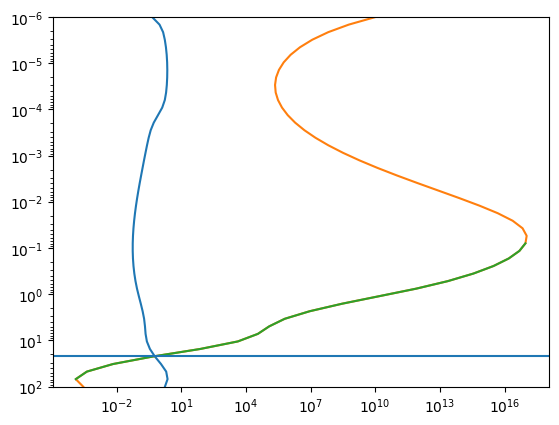

[6.18327509e+03 1.81546749e+04 4.77163064e+03 1.69722868e+02
 1.23572244e+00 4.60206172e-03 5.99633715e-05 6.17517404e-06
 1.71730126e-06 2.98747523e-07 1.79025892e-08 4.56632948e-10
 6.96033766e-12 1.09416369e-13 3.16882539e-15 1.84606391e-16
 1.97638676e-17 3.66818030e-18 1.15089638e-18 6.05697993e-19
 5.44773857e-19 8.89082945e-19 2.75538198e-18 1.48816880e-17
 1.16792123e-16 1.13413512e-15 1.21489273e-14 1.31835817e-13
 1.35644821e-12 1.25435129e-11 1.00475563e-10 6.82599030e-10
 3.86561644e-09 1.82861936e-08 7.40593407e-08 2.75098960e-07
 9.60448104e-07 2.77427474e-06 5.60154847e-06 8.24495637e-06
 9.53415714e-06 8.85917113e-06 6.61496758e-06 3.90881467e-06
 1.78278819e-06 6.04335680e-07 1.43767963e-07 2.18549860e-08
 1.66550426e-09 4.46297014e-11]


TypeError: only integer scalar arrays can be converted to a scalar index

In [101]:
import petitRADTRANS.nat_cst as nc

# Metallicity
met = 10**0.0

# Scale height at each layer
MMW = Chem_4.mass_fractions['MMW']
H = nc.kB*PT_4.temperature / (MMW*nc.amu*10**Chem_4.log_g)

# Mixing length/time-scales
L = 1 * H
t_mix = L**2 / (10**Chem_4.log_Kzz)
#print(t_mix)
#print()
plt.plot(t_mix, PT_4.pressure)


mask_T = (PT_4.temperature > 500) & (PT_4.temperature < 5000)
P = PT_4.pressure[mask_T][::-1]
T = PT_4.temperature[mask_T][::-1]
t_mix = t_mix[mask_T][::-1]

t_CO_CH4_q1 = 1.5e-6 * P**(-1) * met**(-0.7) * np.exp(42000/T)
t_CO_CH4_q2 = 40 * P**(-2) * np.exp(25000/T)
t_CO_CH4 = (1/t_CO_CH4_q1 + 1/t_CO_CH4_q2)**(-1)
ratio = t_mix / t_CO_CH4

plt.plot(t_CO_CH4, P)

mask_decreasing = np.diff(t_CO_CH4/t_mix, append=True) > 0
idx = np.arange(len(t_CO_CH4))[mask_decreasing]

#mask_decreasing = np.diff(t_CO_CH4, append=True) > 0
#idx = np.arange(len(t_CO_CH4))[mask_decreasing]

for i, idx_i in enumerate(idx):
    if i == 0:
        idx_low = idx_i
    elif idx_i != idx[i-1]+1:
        break
    idx_high = idx_i
print(idx_low, idx_high)
print(idx)
#plt.plot(t_CO_CH4[mask_decreasing], P[mask_decreasing])
plt.plot(t_CO_CH4[idx_low:idx_high+1], P[idx_low:idx_high+1])

#mask_decreasing = np.diff(T, prepend=True) < 0
#plt.plot(t_CO_CH4[mask_decreasing], P[mask_decreasing])

plt.xscale('log')
plt.yscale('log')
plt.ylim(1e2,1e-6)

P_quench_CO_CH4 =10**np.interp(
    0, xp=np.log10((t_CO_CH4/t_mix)[mask_decreasing]), 
    fp=np.log10(P[mask_decreasing])
    )
plt.axhline(P_quench_CO_CH4)
plt.show()

#print(t_mix)
#np.diff(t_mix)

print(ratio)

print(np.log10(ratio)[1:idx+1])
print(np.log10(P)[1:idx+1])

idx = np.argwhere(np.diff(ratio) > 0).flatten()[0] # Ratio should be increasing
if idx == 0:
    idx = np.argwhere(np.diff(ratio) > 0).flatten()[1] # Ratio should be increasing
#print(idx)
#P_quench_CO_CH4 = np.interp(0, xp=np.log10(ratio[:idx+1]), fp=np.log10(P[:idx+1]))
#P_quench_CO_CH4 = np.interp(1, xp=ratio[:idx+1], fp=P[:idx+1])
    
P_quench_CO_CH4 = np.interp(
    0, xp=np.sort(np.log10(ratio[1:idx+1])), 
    fp=np.log10(P[1:idx+1])[np.argsort(np.log10(ratio[1:idx+1]))]
    )
#P_quench_CO_CH4 = np.interp(1, xp=ratio[1:idx+1], fp=P[1:idx+1])

print(np.diff(ratio))
#print(np.log10(ratio[:idx+1]))
print(10**P_quench_CO_CH4)
print(P_quench_CO_CH4)

In [48]:
Chem_4.P_quench_CO_CH4

15.264179671752302

In [44]:
Chem_4.log_g

5.200328821900869

In [40]:
print(PT_4.temperature)


[1856.08282992 2082.2359425  2288.3927691  2466.6047458  2610.58147617
 2716.08877196 2781.12182099 2805.85829983 2792.42457857 2744.52688739
 2667.00711131 2565.38073522 2445.40491852 2312.71094691 2172.5204771
 2029.45148783 1887.4092053  1749.55011652 1618.30343437 1495.43347875
 1382.12761065 1279.09680073 1186.67893678 1104.93805629 1033.75549732
  972.91132792  922.15630761  881.27611757  850.15079408  828.81338884
  817.51307332  816.78947924  827.56739106  851.28451874  890.07080903
  947.00694241 1026.50454067 1132.13334185 1256.89774417 1386.43017668
 1499.76003932 1571.63946008 1622.64307761 1741.12392636 2050.93841284
 2660.15140946 3529.9814688  4425.38908579 4839.98588249 4264.33154025]


In [34]:
PT_4.temperature

array([1856.08282992, 2082.2359425 , 2288.3927691 , 2466.6047458 ,
       2610.58147617, 2716.08877196, 2781.12182099, 2805.85829983,
       2792.42457857, 2744.52688739, 2667.00711131, 2565.38073522,
       2445.40491852, 2312.71094691, 2172.5204771 , 2029.45148783,
       1887.4092053 , 1749.55011652, 1618.30343437, 1495.43347875,
       1382.12761065, 1279.09680073, 1186.67893678, 1104.93805629,
       1033.75549732,  972.91132792,  922.15630761,  881.27611757,
        850.15079408,  828.81338884,  817.51307332,  816.78947924,
        827.56739106,  851.28451874,  890.07080903,  947.00694241,
       1026.50454067, 1132.13334185, 1256.89774417, 1386.43017668,
       1499.76003932, 1571.63946008, 1622.64307761, 1741.12392636,
       2050.93841284, 2660.15140946, 3529.9814688 , 4425.38908579,
       4839.98588249, 4264.33154025])